<a href="https://colab.research.google.com/github/songqsh/foo1/blob/master/src/ode02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch.autograd import grad

import numpy as np
import matplotlib.pyplot as plt

__Goal__

We want to solve ODE
$$u''(x) - 20 = 0,  u(-1) = -12, u(1) = 6, x\in [-1,1]$$
with neural network and compare this with true solution $u(x) = 10 x^2 +9x - 13$.

__Method__

- Build a neural network, say $v(x;w)$, where $x$ is 1-d input and $w$ is weight. 
- Set loss function as
$$l(w) = \frac{1}{10} 
\sum_{j=1}^{10} \Big(\frac{\partial^2}{\partial_{xx}} v(j/10, w) - 1 \Big)^2 + (v(0) - 1)^2 + (v(1) - 1)^2.$$
- Use an optimizer to minimize the loss


In [0]:
#parameters
diffusion0 = 1.
drift0 = 0.
run_cost0 = -20.
l_val0 = -12.
r_val0 = 6.

l_end = -1.
r_end = 1.
mesh_n = 20
mesh_x = torch.linspace(l_end, r_end, mesh_n +1, dtype = torch.float, requires_grad=True).reshape(mesh_n+1,1)


In [0]:
#normalize
c_y = np.max([np.abs(l_val0), np.abs(r_val0)])
diffusion = diffusion0
drift= drift0; 
run_cost = run_cost0/c_y
l_val = l_val0/c_y
r_val = r_val0/c_y


In [4]:
H1 = 5; H2 = 5 #number of hidden layer
model = nn.Sequential(
    nn.Linear(1, H1), 
    nn.Sigmoid(),
    nn.Linear(H1, H2),
    nn.Sigmoid(),
    nn.Linear(H2,1)
)

for p in model.parameters():
  print(p)
#model(torch.randn(5,1))

Parameter containing:
tensor([[ 0.3082],
        [ 0.0373],
        [-0.8968],
        [ 0.1171],
        [-0.9723]], requires_grad=True)
Parameter containing:
tensor([ 0.5452, -0.8017,  0.2476,  0.9348, -0.7730], requires_grad=True)
Parameter containing:
tensor([[ 0.0484, -0.2227, -0.0316, -0.1291,  0.1836],
        [-0.0318, -0.3983, -0.1365, -0.0761,  0.1924],
        [-0.1712, -0.3857,  0.2994, -0.1483,  0.2743],
        [ 0.1218,  0.0734,  0.4072,  0.1724,  0.0417],
        [-0.1662, -0.4039, -0.1691,  0.0525,  0.2111]], requires_grad=True)
Parameter containing:
tensor([ 0.2521,  0.0845,  0.1354,  0.2775, -0.1011], requires_grad=True)
Parameter containing:
tensor([[-0.0323,  0.2888,  0.1991,  0.0815, -0.3002]], requires_grad=True)
Parameter containing:
tensor([0.1479], requires_grad=True)


In [0]:
def loss1(model, mesh_x, drift, run_cost): #loss in the interior
  loss = 0.
  for x in mesh_x[1:]:
    y = model(x) #function value
    y_g1 = grad(y, x, create_graph=True)[0] #first order derivative

    y_g2 = grad(y_g1, x, create_graph=True)[0] #second order
    #print('y_g2', y_g2) 

    loss = loss + torch.pow(y_g2*diffusion + y_g1*drift + run_cost, 2)
    
  return torch.div(loss, mesh_x.shape[0])

#loss_total = loss interior + loss boundary
def loss_tot(model, mesh_x, drfit, run_cost, l_val, r_val):
  l1 = loss1(model, mesh_x, drift, run_cost) #loss interior
  l0 = torch.pow(model(mesh_x[0]) - l_val, 2) + \
        torch.pow(model(mesh_x[-1]) - r_val, 2) #loss boundary
  return torch.add(l1,l0)

#loss_tot(model, mesh_x, drift, run_cost, l_val, r_val)  

In [0]:
#optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=.7)

In [7]:
# Train the model
#num_epochs = 40
epoch_n = 1000
print_n = 10
epoch_per_print= np.floor(epoch_n/print_n)

for epoch in range(epoch_n):

    # Forward pass
    loss = loss_tot(model, mesh_x, drift, run_cost, l_val, r_val)  
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % epoch_per_print == 0:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epoch_n, loss.item()))

Epoch [100/1000], Loss: 0.5763
Epoch [200/1000], Loss: 0.5098
Epoch [300/1000], Loss: 0.4608
Epoch [400/1000], Loss: 0.0174
Epoch [500/1000], Loss: 0.0022
Epoch [600/1000], Loss: 0.0014
Epoch [700/1000], Loss: 0.0011
Epoch [800/1000], Loss: 0.0008
Epoch [900/1000], Loss: 0.0007
Epoch [1000/1000], Loss: 0.0005


In [0]:
learnedfun = lambda x: c_y*model(x)

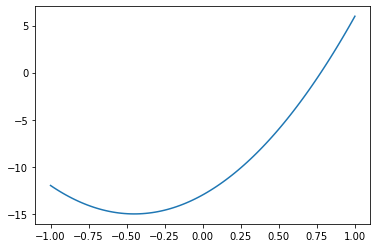

In [9]:
true_fun = lambda x: 10*x**2+9*x-13
xx = np.linspace(-1,1,100)
plt.plot(xx, true_fun(xx))

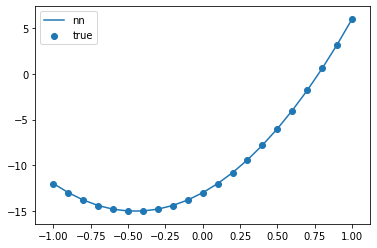

In [10]:
x_np = mesh_x.detach().numpy()
#y_np = model(mesh_x).detach().numpy()
y_np = learnedfun(mesh_x).detach().numpy()
plt.plot(x_np, y_np, label='nn')
true_y = true_fun(x_np)
plt.scatter(x_np, true_y, label = 'true')
plt.legend()